In [87]:
import msprime
import numpy as np
from trails.optimizer import trans_emiss_calc
from trails.cutpoints import cutpoints_AB, cutpoints_ABC
from trails.get_joint_prob_mat import get_joint_prob_mat
from trails.get_emission_prob_mat import get_emission_prob_mat
import re
import pandas as pd
import sys
%load_ext rpy2.ipython

n_int_AB = 1
n_int_ABC = 1
sim = 0

# mu = 2e-8
# N_AB = 20000*mu
# N_ABC = 50000*mu
# t_1 = 160000*mu
# t_2 = 40000*mu
# t_3 = t_1*5
# r = 1e-8/mu
# mu = mu/mu

mu = 2e-8
N_AB = 50000
N_ABC = 10000
t_1 = 160000
t_2 = 40000
t_3 = t_1*5
r = 1e-8


n_sites = 10000000
t_upper = t_3-cutpoints_ABC(n_int_ABC, 1/N_ABC)[-2]
t_out = t_1+t_2+t_3+N_ABC*2

demography = msprime.Demography()
demography.add_population(name="A", initial_size=N_AB)
demography.add_population(name="B", initial_size=N_AB)
demography.add_population(name="C", initial_size=N_AB)
demography.add_population(name="D", initial_size=N_AB)
demography.add_population(name="AB", initial_size=N_AB)
demography.add_population(name="ABC", initial_size=N_ABC)
demography.add_population(name="ABCD", initial_size=N_ABC)
demography.add_population_split(time=t_1, derived=["A", "B"], ancestral="AB")
demography.add_population_split(time=t_1+t_2, derived=["AB", "C"], ancestral="ABC")
demography.add_population_split(time=t_1+t_2+t_3, derived=["ABC", "D"], ancestral="ABCD")

ts = msprime.sim_ancestry(
    {"A": 1, "B": 1, "C": 1,
     "D": 1
    },
    demography=demography,
    recombination_rate=r,
    sequence_length=n_sites,
    ploidy=1,
    random_seed = 1
)

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [88]:
c = mu
params = (
    t_1*c, t_1*c, (t_1+t_2)*c, t_2*c, t_upper*c, t_out*c,
    N_AB*c, N_ABC*c,
    r/c, n_int_AB, n_int_ABC
)

transitions, emissions, starting, hidden_states, observed_states = trans_emiss_calc(*params)

dct = {v: k for k, v in observed_states.items()}

In [89]:
1-sum(starting@emissions[:,[dct[i] for i in ['AAAA', 'CCCC', 'GGGG', 'TTTT']]])

0.04695553864957369

In [90]:
params

(0.0032, 0.0032, 0.004, 0.0008, 0.016, 0.0204, 0.001, 0.0002, 0.5, 1, 1)

In [91]:
# # mu = 2e-8
# # N_AB = 5000*mu
# # N_ABC = 50000*mu
# # t_1 = 160000*mu
# # t_2 = 40000*mu
# # t_3 = t_1*5
# # r = 1e-8/mu
# # mu = mu/mu
# 
# # mu = 2e-8
# # N_AB = 50000
# # N_ABC = 50000
# # t_1 = 160000
# # t_2 = 40000
# # t_3 = t_1*5
# # r = 1e-8
# 
# n_sites = 10000000
# t_upper = t_3-cutpoints_ABC(n_int_ABC, 1/N_ABC)[-2]
# t_out = t_1+t_2+t_3+N_ABC*2
# 
# mu_prime = (4/3)
# 
# hidden_names = hidden_states
# 
# params = (t_1/N_ABC,    t_1/N_ABC,  t_2/N_ABC,    (t_1+t_2)/N_ABC, t_upper/N_ABC, t_out/N_ABC,
#     r*N_ABC,  r*N_ABC,  r*N_ABC,  r*N_ABC,  r*N_ABC, 
#     1/N_AB*N_ABC, 1/N_AB*N_ABC, 1/N_AB*N_ABC, 1/N_AB*N_ABC, 1/N_ABC*N_ABC,
#     n_int_AB, n_int_ABC,
#     mu_prime*N_ABC*mu, mu_prime*N_ABC*mu, mu_prime*N_ABC*mu, mu_prime*N_ABC*mu, mu_prime*N_ABC*mu, mu_prime*N_ABC*mu
#          )
# em = get_emission_prob_mat(*params)
# em.hidden_state = em.hidden_state.astype("category")
# em.hidden_state.cat.set_categories(hidden_names)
# em = em.sort_values(["hidden_state"])
# em = em.iloc[: , 1:]
# observed_names = list(em.columns)
# observed_names = dict(zip(range(len(observed_names)), observed_names))
# b = np.array(em)
# emissions = b

In [92]:
dct_hid = {v: k for k, v in hidden_states.items()}

cut_AB = t_1+cutpoints_AB(n_int_AB, t_2, 1/N_AB)
cut_ABC = t_1+t_2+cutpoints_ABC(n_int_ABC, 1/N_ABC)


In [93]:
left_lst = []
right_lst = []
tree_state = []
t_AB_vec = []
t_ABC_vec = []
# For each tree in the sample
for t in ts.trees():
    # Append start coordinate
    left_lst.append(t.interval.left)
    # Append end coordinate
    right_lst.append(t.interval.right-1)
    # Get all non-zero coalescent times
    ntimes = [ts.nodes()[n].time for n in t.nodes() if ts.nodes()[n].time!=0]
    ntimes = sorted(ntimes)
    # Get time of the first event
    mint = ntimes[0]
    mint2 = ntimes[1]
    # Find topology
    find_re = re.findall("n\d,n\d", t.as_newick(include_branch_lengths=False))[0]
    # Sort species within topology
    find_re = sorted(find_re.split(','))
    # If V0 or V1
    if find_re == ['n0', 'n1']:
        # If the time of the first coalescent is larger than the deepest speciation event
        if mint>=(t_1+t_2):
            state = (1, (mint>cut_ABC).sum()-1, (mint2>cut_ABC).sum()-1)
            # Append V1 state
        else:
            state = (0, (mint>cut_AB).sum()-1, (mint2>cut_ABC).sum()-1)
            # Append V0 state
    # If V2
    elif find_re == ['n0', 'n2']:
        state = (2, (mint>cut_ABC).sum()-1, (mint2>cut_ABC).sum()-1)
    # If V3
    elif find_re == ['n1', 'n2']:
        state = (3, (mint>cut_ABC).sum()-1, (mint2>cut_ABC).sum()-1)
    else:
        state = (4, (mint>cut_ABC).sum()-1, (mint2>cut_ABC).sum()-1)
    tree_state.append(state)
    t_AB_vec.append(mint)
    t_ABC_vec.append(mint2)

len_lst = (np.array(right_lst)-np.array(left_lst)+1)
# print((((np.array(tree_state)==2)*len_lst).sum()+((np.array(tree_state)==3)*len_lst).sum())/n_sites)

dat_sim = pd.DataFrame({'state':[dct_hid[i] for i in tree_state], 'len':len_lst})
# dat_sim = pd.DataFrame({'state':tree_state, 'len':len_lst})
dat_sim['group'] = (dat_sim.state != dat_sim.state.shift()).cumsum()
dat_sim = dat_sim.groupby(['group', 'state']).sum().reset_index()

new_df = pd.DataFrame()
new_df['from'] = dat_sim['state']
new_df['to'] = dat_sim['state']
new_df['n'] = dat_sim['len']

new_df_2 = pd.DataFrame()
new_df_2['from'] = dat_sim['state']
new_df_2['to'] = dat_sim['state'].shift(-1)
new_df_2 = new_df_2.dropna()
new_df_2['to'] = new_df_2['to'].astype(np.int64)
new_df_2['n'] = 1

new_df_tot = pd.concat([new_df, new_df_2])
new_df_tot = new_df_tot.groupby(['from', 'to']).sum().reset_index()
# # new_df_tot['n'] = new_df_tot['n'] / new_df_tot.groupby('from')['n'].transform('sum')
new_df_tot['n'] = new_df_tot['n'] / new_df_tot['n'].sum()

new_df_tot_save = new_df_tot

new_df_tot_save['from'] = [hidden_states[i] for i in new_df_tot_save['from']]
new_df_tot_save['to'] = [hidden_states[i] for i in new_df_tot_save['to']]
new_df_tot_save.to_csv('ms_transition_{}_{}_{}.csv'.format(n_int_AB, n_int_ABC, sim), index = False)



In [94]:
#### Mutations
dct = {v: k for k, v in observed_states.items()}

jc69 = msprime.JC69()

mutated_ts = msprime.sim_mutations(ts, rate=mu, model=jc69)
# mutated_ts.draw_svg()

nochange_lst = [dct['AAAA'], dct['CCCC'], dct['TTTT'], dct['GGGG']]
sim_genome = np.random.choice(nochange_lst, n_sites)

mut_lst = []
mut_loc = []
for variant in mutated_ts.variants():
    mut_loc.append(variant.site.position)
    # print(variant.site.mutations[0].node)
    # print(variant.site.mutations[0].time)
    mut_lst.append(''.join([variant.alleles[i] for i in variant.genotypes]))
# [dct[i] for i in mut_lst]

for i in range(len(mut_loc)):
    sim_genome[int(mut_loc[i])] = dct[mut_lst[i]]


df = dat_sim.reset_index()
df = df.reindex(df.index.repeat(df.len))
df['site'] = sim_genome
df = df.groupby(['state', 'site']).size().reset_index()
df[0] = df[0] / df.groupby('state')[0].transform('sum')
df_save = df.copy()
df_save['state'] = [hidden_states[i] for i in df_save['state']]
df_save['site'] = [observed_states[i] for i in df_save['site']]
df_save.columns = ['state', 'site', 'prob']
df_save.to_csv('ms_emission_{}_{}_{}.csv'.format(n_int_AB, n_int_ABC, sim), index = False)


In [95]:
counts = np.unique(sim_genome, return_counts=True)
(n_sites-sum(counts[1][[np.where(counts[0] == dct[i])[0][0] for i in ['AAAA', 'CCCC', 'GGGG', 'TTTT']]]))/n_sites

0.0470424

In [96]:
tr_mut_save = pd.DataFrame(emissions).melt(ignore_index = False).reset_index()
tr_mut_save.columns = ['state', 'site', 'prob']
tr_mut_save['state'] = [hidden_states[i] for i in tr_mut_save['state']]
tr_mut_save['site'] = [observed_states[i] for i in tr_mut_save['site']]
tr_mut_save.to_csv('tr_emission_{}_{}.csv'.format(n_int_AB, n_int_ABC), index = False)

Rows: 5376 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): state, site
dbl (1): prob

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 3059 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): state, site
dbl (1): prob

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


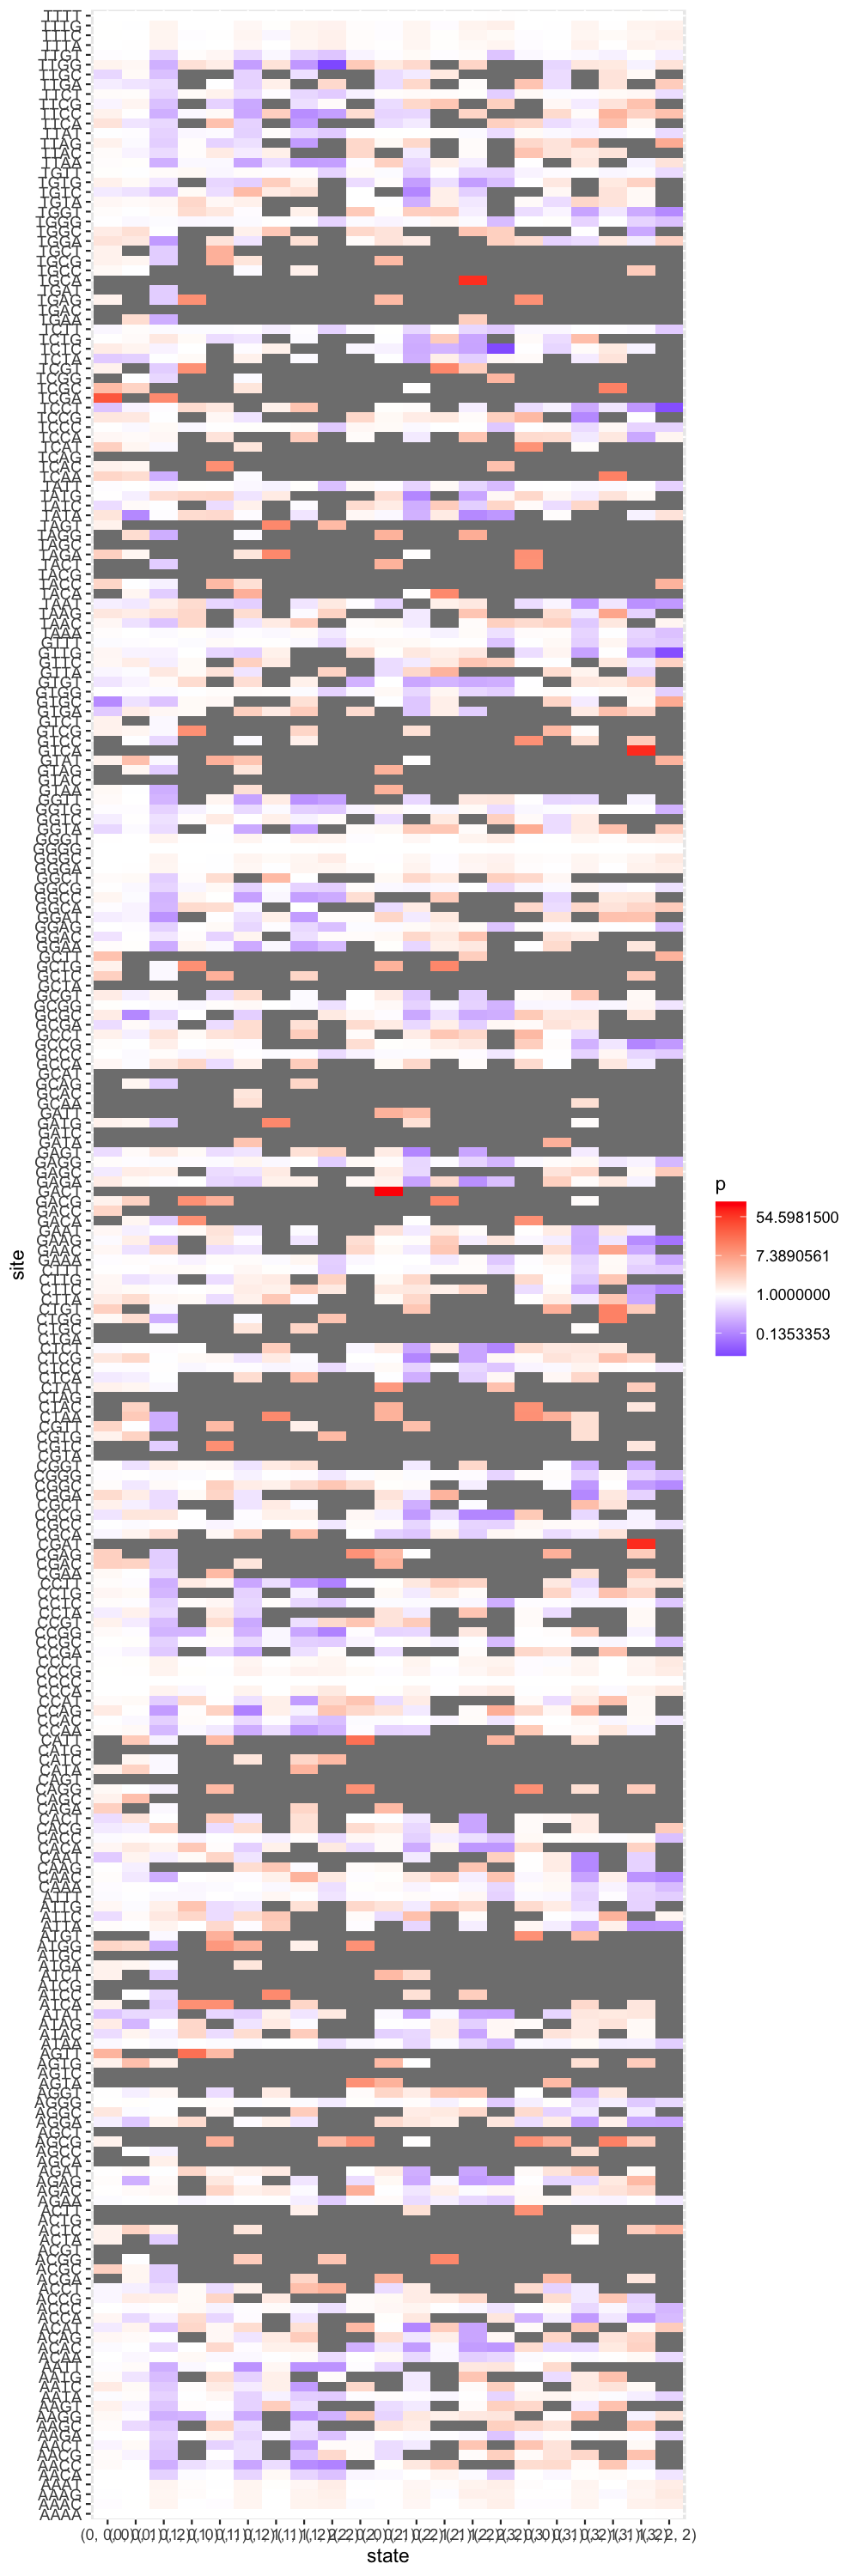

In [97]:
%%R -w 1000 -h 3000 -r 150

library(tidyverse)

tr <- read_csv('tr_emission_1_3.csv') %>% mutate(type = 'tr')
ms <- read_csv('ms_emission_1_3_0.csv') %>% mutate(type = 'ms')

bind_rows(tr, ms) %>%
    pivot_wider(values_from = prob, names_from = type) %>%
    mutate(p = ms/tr) %>%
    arrange((state), site) %>%
    ggplot() +
    geom_tile(aes(state, site, fill = p)) +
    scale_fill_gradient2(low = "blue",
                       mid = "white",
                       high="red",
                       midpoint = 0, 
                       # limits = c(1/5, 5),
                       trans = 'log')


In [98]:
params = (t_1/N_ABC,    t_1/N_ABC,  t_2/N_ABC,    (t_1+t_2)/N_ABC,
    r*N_ABC,  r*N_ABC,  r*N_ABC,  r*N_ABC,  r*N_ABC, 
    1/N_AB*N_ABC, 1/N_AB*N_ABC, 1/N_AB*N_ABC, 1/N_AB*N_ABC, 1/N_ABC*N_ABC,
    n_int_AB, n_int_ABC)



tr = get_joint_prob_mat(*params)

tr_dat_save = pd.DataFrame(tr)
tr_dat_save.columns = ['from', 'to', 'n']
tr_dat_save.to_csv('tr_transition_{}_{}.csv'.format(n_int_AB, n_int_ABC), index = False)

In [99]:
params

(16.0,
 16.0,
 4.0,
 20.0,
 0.0001,
 0.0001,
 0.0001,
 0.0001,
 0.0001,
 0.2,
 0.2,
 0.2,
 0.2,
 1.0,
 1,
 1)

In [100]:
%%R

library(tidyverse)

tr <- read_csv('tr_transition_1_1.csv') %>% mutate(type = 'tr')
ms <- read_csv('ms_transition_1_1_0.csv') %>% mutate(type = 'ms')

bind_rows(tr, ms) %>%
    pivot_wider(values_from = n, names_from = type) %>%
    mutate(p = ms/tr) 
    # %>%
    # ggplot() +
    # geom_tile(aes(to, from, fill = p)) +
    # scale_fill_viridis_c() 



Rows: 16 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): from, to
dbl (1): n

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 16 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): from, to
dbl (1): n

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
# A tibble: 16 × 5
   from      to               tr        ms     p
   <chr>     <chr>         <dbl>     <dbl> <dbl>
 1 (0, 0, 0) (0, 0, 0) 0.550     0.549     0.998
 2 (0, 0, 0) (1, 0, 0) 0.0000873 0.0000808 0.926
 3 (1, 0, 0) (0, 0, 0) 0.0000873 0.0000810 0.928
 4 (0, 0, 0) (2, 0, 0) 0.0000873 0.0000844 0.967
 5 (2, 0, 0) (0, 0, 0) 0.0000873 0.0000818 0.938
 6 (0, 0, 0) (3, 0, 0) 0.0000873 0.000

In [72]:
%%R

library(tidyverse)

tr <- read_csv('tr_transition_1_1.csv') %>% mutate(type = 'tr')
ms <- read_csv('ms_transition_1_1_0.csv') %>% mutate(type = 'ms')

bind_rows(tr, ms) %>%
    pivot_wider(values_from = n, names_from = type) %>%
    mutate(p = ms/tr) 
    # %>%
    # ggplot() +
    # geom_tile(aes(to, from, fill = p)) +
    # scale_fill_viridis_c() 



Rows: 16 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): from, to
dbl (1): n

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 16 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): from, to
dbl (1): n

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
# A tibble: 16 × 5
   from      to               tr        ms     p
   <chr>     <chr>         <dbl>     <dbl> <dbl>
 1 (0, 0, 0) (0, 0, 0) 0.550     0.549     0.998
 2 (0, 0, 0) (1, 0, 0) 0.0000873 0.0000868 0.995
 3 (1, 0, 0) (0, 0, 0) 0.0000873 0.0000860 0.986
 4 (0, 0, 0) (2, 0, 0) 0.0000873 0.0000795 0.911
 5 (2, 0, 0) (0, 0, 0) 0.0000873 0.0000810 0.928
 6 (0, 0, 0) (3, 0, 0) 0.0000873 0.000